In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nltk
from textblob import TextBlob, Word
plt.style.use("fivethirtyeight")
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display
import plotly.express as px

import itertools
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report,  confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation,  TruncatedSVD, NMF

In [95]:
papers = pd.read_excel('Paper_dataCompiled.xlsx')
papers.head()

,Source,Title,Abstract,Journal,Author,Date,Keyword,Keyword2,Keyword3,Keyword4,Keyword5,General,Citation,Field,Search Term
0,https://www.semanticscholar.org/paper/Space-ch...,Space-charge limited photocurrent.,""":""In 1971 Goodman and Rose predicted the occu...",Physical review letters,Valentin D. Mihailetchi and Jurjen Wildeman an...,2005,Fullerenes,Immunostimulating conjugate (antigen),Switch Device Component,Semiconductors,light intensity,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Mihailetchi2005SpacechargeLP, title=...",Physics,Space
1,https://www.semanticscholar.org/paper/Separabl...,Separable dual-space Gaussian pseudopotentials.,""":""We present pseudopotential coefficients for...","Physical review. B, Condensed matter",Goedecker and Teter and Hutter,1996,Dual,Normal Statistical Distribution,Multiplication,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Goedecker1996SeparableDG, title={Sep...",Physics,Space
2,https://www.semanticscholar.org/paper/Canonica...,Canonical dynamics: Equilibrium phase-space di...,""":""Nose has modified Newtonian dynamics so as ...","Physical review. A, General physics",Hoover,1985,Normal Statistical Distribution,Friction,CNS disorder,Test scaling,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Hoover1985CanonicalDE, title={Canoni...",Physics,Space
3,https://www.semanticscholar.org/paper/Flat-spa...,Flat-space chiral gravity.,""":""We provide the first evidence for a hologra...",Physical review letters,Arjun Bagchi and St{\'e}phane Detournay and Da...,2012,Holographic principle,Quantum field theory,Calcifying Fibrous Pseudotumor,Hornbostelâ€“Sachs,Battery management system,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Bagchi2012FlatspaceCG, title={Flat-s...",Physics,Space
4,https://www.semanticscholar.org/paper/Polariza...,Polarization demultiplexing in Stokes space.,""":""A technique is demonstrated for polarizatio...",Optics express,Bogdan Szafraniec and Bernd Nebendahl and Todd...,2010,chaperone-mediated autophagy,algorithm,Fiber Optic Cables,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Szafraniec2010PolarizationDI, title=...",Physics,Space


In [96]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
Source         2000 non-null object
Title          1990 non-null object
Abstract       2000 non-null object
Journal        1756 non-null object
Author         2000 non-null object
Date           2000 non-null object
Keyword        1852 non-null object
Keyword2       1626 non-null object
Keyword3       1368 non-null object
Keyword4       1123 non-null object
Keyword5       896 non-null object
General        2000 non-null object
Citation       2000 non-null object
Field          2000 non-null object
Search Term    2000 non-null object
dtypes: object(15)
memory usage: 234.5+ KB


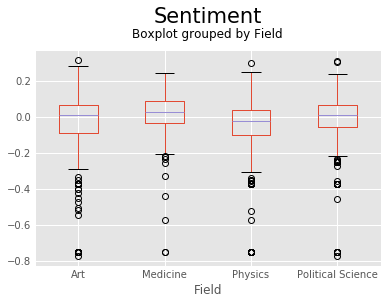

In [58]:
# Sentiment
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

papers["Sentiment"] = papers["Abstract"].apply(detect_sentiment)

ax= papers.boxplot(column="Sentiment", by="Field")
ax.set_title("Sentiment", fontsize=21, y=1.1);

# Could try by sentence instead of by whole abstract.

In [59]:
papers["Field"].value_counts(normalize=True)

# So null model would be correct 25% of the time

Medicine             0.25
Political Science    0.25
Art                  0.25
Physics              0.25
Name: Field, dtype: float64

# need to vectorize BEFORE train-test split

In [102]:
from nltk.corpus import stopwords
stp = stopwords.words('english')
stp += stopwords.words('spanish')
stop_words_combined =  set(stp)
vect = CountVectorizer(min_df=2, ngram_range=(1,4), stop_words=set(stp))
X = vect.fit_transform(papers["Abstract"])

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# one hot encoding of labels
+ useful for some models and plots

In [103]:
y = papers['Field']
m = LabelEncoder()
m.fit(y)
list(m.classes_)

['Art', 'Medicine', 'Physics', 'Political Science']

In [104]:
y_hot_labels = m.transform(y)
y_hot_labels

array([2, 2, 2, ..., 0, 0, 0])

In [105]:
m.inverse_transform(y_hot_labels)

array(['Physics', 'Physics', 'Physics', ..., 'Art', 'Art', 'Art'],
      dtype=object)

In [106]:
#X_train, X_test, y_train, y_test = train_test_split(X_dtm, papers["Field"])

# Need to train test split by category

#Fix split- shuffle
rs = StratifiedShuffleSplit(n_splits=1, random_state=24, test_size=0.25, train_size=None)
for train_index, test_index in rs.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)


X_train = X[train_index,:]
X_test =  X[test_index,:]
y_train = y[train_index]
y_test = y[test_index]

TRAIN: [1327  438 1424 ... 1412  866 1573] TEST: [ 248  988 1480 1512  363 1640 1699 1538  870  326  389   33  114  135
  580  526 1052   88 1229  426  193  391  122 1874 1190 1084  373 1692
  401  906 1723 1843 1774 1854 1370  671  468 1510 1923   93 1035 1691
 1871  559 1664   85 1049 1415 1759 1939 1437  148 1888  316 1147  550
  210 1575  212 1733 1899 1504 1338 1698  376 1797 1595 1279 1021 1228
  824  974  593 1629 1707 1395 1451  726  624  408  506 1211 1408 1057
  416  929  239   20  566 1895 1826 1821 1555 1309 1783 1130 1709  459
  112  684  472 1213 1305 1829   46  561  180  943  496 1651  755 1801
  758  946 1018 1891  452  451 1185  208  455 1060  587  770 1358  670
 1064 1960  858  622 1978  768 1606   99 1789 1717  487  473   28 1090
 1410 1918  635 1150 1436 1768 1044 1260 1318 1212 1482    6  752  538
 1252  214 1200 1086   78  630 1528  860 1248 1823 1550 1048  840 1861
  518  263  903 1267 1156 1633 1879  554  679 1508 1284  318  111 1365
  433  375 1293  682  121  9

# Look at how even our split is

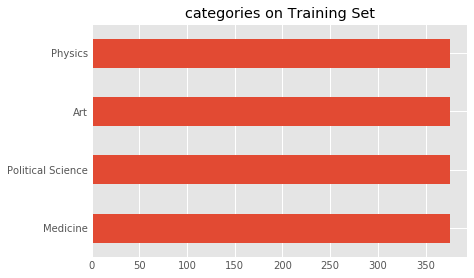

In [107]:
plotTrain = pd.DataFrame(data=y_train)
plotTrain["yTrain"] = pd.DataFrame(data=y_train)

plt.style.use("ggplot")
plotTrain.yTrain.value_counts().plot(kind="barh")
plt.title("categories on Training Set");

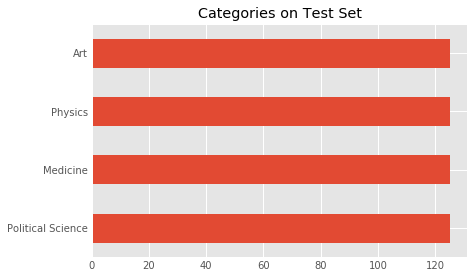

In [108]:
# Look at how even our test split is
plotTest = pd.DataFrame(data=y_test)
plotTest["yTest"] = pd.DataFrame(data=y_test)

plt.style.use("ggplot")
plotTest.yTest.value_counts().plot(kind="barh")
plt.title("Categories on Test Set");

# Naive bayes classification model

In [109]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

        
print("naive bayes Scoring")
Y_pred = nb.predict(X_test)
cr = classification_report(y_test, Y_pred)
print( cr)

# to save model
#with open(path + path2 + 'NB_model.pickle', 'rb') as f:  
#    NBmodel = pickle.load(f,encoding='latin1')

naive bayes Scoring
                   precision    recall  f1-score   support

              Art       0.91      0.87      0.89       125
         Medicine       0.94      0.96      0.95       125
          Physics       0.94      0.93      0.94       125
Political Science       0.93      0.97      0.95       125

        micro avg       0.93      0.93      0.93       500
        macro avg       0.93      0.93      0.93       500
     weighted avg       0.93      0.93      0.93       500



In [110]:
# Calculate accuracy.
print((metrics.accuracy_score(y_test, Y_pred)))

0.932


In [116]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Classifier Confusion matrix',
                          cmap=plt.cm.coolwarm):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "white", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    
    return plt

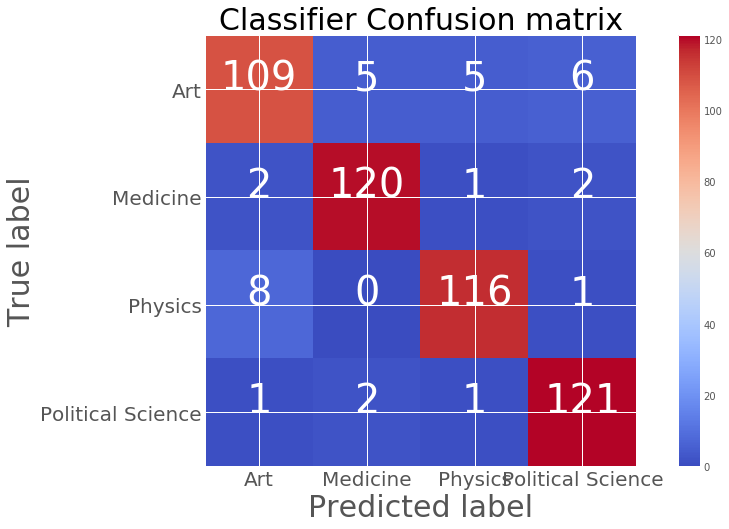

In [117]:
cm = confusion_matrix(y_test, Y_pred)
fig = plt.figure(figsize=(12, 7))
plot = plot_confusion_matrix(cm, classes=m.classes_, normalize=False)
#plt.savefig(path + path2 + "NB_confusion_matrix.svg")
plt.show()

# LDA on all papers
+ Do LDA on all abstracts with 4 topics to see if it can correctly classify our data
+ works well

In [113]:
def topic_mod_lda(data,topics=5,iters=10,ngram_min=1, ngram_max=3, max_df=0.6, max_feats=5000, random_state=42):
    
    """ use count vectorizer to turn words into numbers for each document(rows)
    then use Latent Dirichlet Allocation to get topics"""
    
    vectorizer = CountVectorizer(ngram_range=(ngram_min,ngram_max), 
                             stop_words=set(stp), 
                             max_df = max_df, 
                             max_features=max_feats)
        

    #  `fit (train), then transform` to convert text to a bag of words

    vect_data = vectorizer.fit_transform(data)
    
    lda = LatentDirichletAllocation(n_components=topics,
                                    max_iter=iters,
                                    random_state=random_state,
                                    learning_method='online',
                                    n_jobs=-1)
    
    lda_data = lda.fit_transform(vect_data)
    
    # to display a list of topic words and their scores 
    def display_topics(model, feature_names, no_top_words):
        for ix, topic in enumerate(model.components_):
            print("Topic ", ix)
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
    display_topics(lda, vectorizer.get_feature_names(),20)
    
    return vectorizer, vect_data, lda, lda_data

In [114]:
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(papers["Abstract"],
                                                         topics=4,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=.5, 
                                                         max_feats=2000,
                                                         random_state=42)


Topic  0
space time radiation two field system results model phase energy using based show systems quantum optical one data theory dimensional
Topic  1
sports injuries injury athletes may risk training exercise performance patients sport physical concussion activity related high studies study age participation
Topic  2
color art paper images used image using based system different one two work new digital visual colour use results also
Topic  3
international health research countries social information development world science global public national new data article also policy education human study


In [115]:
topic_ind = np.argmax(lda_data, axis=1)
topic_ind.shape

#create labels for plotting with matplotlib 
labels_4_mpl = topic_ind

# put into dataframe for plotly
tsne_labels = pd.DataFrame(topic_ind)

# save to csv here if not assigning labels and leaving as numbers
#tsne_labels.to_csv('./data/topic_numbers.csv')

In [118]:
# need to look at the conent above to be sure these are correctly assigned
tsne_labels[tsne_labels==0] = "Physics"
tsne_labels[tsne_labels==1] = "Medicine"
tsne_labels[tsne_labels==2] = "Art"
tsne_labels[tsne_labels==3] = "Political Science"


In [119]:
papers["LDA Classification"]= tsne_labels

In [120]:
papers.head()

,Source,Title,Abstract,Journal,Author,Date,Keyword,Keyword2,Keyword3,Keyword4,Keyword5,General,Citation,Field,Search Term,LDA Classification
0,https://www.semanticscholar.org/paper/Space-ch...,Space-charge limited photocurrent.,""":""In 1971 Goodman and Rose predicted the occu...",Physical review letters,Valentin D. Mihailetchi and Jurjen Wildeman an...,2005,Fullerenes,Immunostimulating conjugate (antigen),Switch Device Component,Semiconductors,light intensity,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Mihailetchi2005SpacechargeLP, title=...",Physics,Space,Physics
1,https://www.semanticscholar.org/paper/Separabl...,Separable dual-space Gaussian pseudopotentials.,""":""We present pseudopotential coefficients for...","Physical review. B, Condensed matter",Goedecker and Teter and Hutter,1996,Dual,Normal Statistical Distribution,Multiplication,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Goedecker1996SeparableDG, title={Sep...",Physics,Space,Physics
2,https://www.semanticscholar.org/paper/Canonica...,Canonical dynamics: Equilibrium phase-space di...,""":""Nose has modified Newtonian dynamics so as ...","Physical review. A, General physics",Hoover,1985,Normal Statistical Distribution,Friction,CNS disorder,Test scaling,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Hoover1985CanonicalDE, title={Canoni...",Physics,Space,Physics
3,https://www.semanticscholar.org/paper/Flat-spa...,Flat-space chiral gravity.,""":""We provide the first evidence for a hologra...",Physical review letters,Arjun Bagchi and St{\'e}phane Detournay and Da...,2012,Holographic principle,Quantum field theory,Calcifying Fibrous Pseudotumor,Hornbostelâ€“Sachs,Battery management system,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Bagchi2012FlatspaceCG, title={Flat-s...",Physics,Space,Physics
4,https://www.semanticscholar.org/paper/Polariza...,Polarization demultiplexing in Stokes space.,""":""A technique is demonstrated for polarizatio...",Optics express,Bogdan Szafraniec and Bernd Nebendahl and Todd...,2010,chaperone-mediated autophagy,algorithm,Fiber Optic Cables,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Szafraniec2010PolarizationDI, title=...",Physics,Space,Physics


In [121]:
# accuracy for the LDA method
print((accuracy_score(papers["Field"], papers["LDA Classification"])))

0.8735


# use classifer NB model  on all data to get prediction 

In [122]:
pred_class = nb.predict(X)

papers["NB Classification"]= pred_class
print((metrics.accuracy_score(papers["Field"], papers["NB Classification"])))

0.971


# tsne 

In [256]:
labels_t = pd.DataFrame(labels_4_mpl)
labels_t.rename(columns={0:'topic'},inplace=True)

In [257]:
# you can then do tsne with this to see if similar docs have been assigned similar topics. 
 
# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=3, verbose=1, random_state=44, angle=.50,
                  perplexity=18,early_exaggeration=1,learning_rate=30.0)#, init='pca'
 
# 20-D -> 3-D
tsne_lda = tsne_model.fit_transform(lda_data)
tsne_data = pd.DataFrame(tsne_lda,columns=['zero','one','two'])
 
ty = pd.merge(tsne_data,labels_t, left_index=True, right_index=True, how='outer')
ty.topic.astype(str,inplace=True)
ty.head()
 

[t-SNE] Computing 55 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 0.761229
[t-SNE] KL divergence after 1000 iterations: 0.510428


,zero,one,two,topic
0,10.080636,-16.544899,9.299607,2
1,8.254885,-10.685078,-2.171875,2
2,3.473177,8.882366,18.358177,2
3,-0.408806,-11.742293,6.727388,2
4,-15.337961,-12.919457,3.663917,2


In [258]:
# plot interactive 3D
fig = px.scatter_3d(ty, x='zero', y='one', z='two',
              color='topic', title='25 topics', opacity=0.99)#  size_max=28,
fig.show()

# assign papers to each category pased on the NB classifier

In [151]:
art_papers= papers.where(papers["NB Classification"]=="Art")
art_papers= art_papers.dropna(how='all')
art_papers["Abstract"][0:5]

20     ":"Cultured cells are known to form focal and ...
25     ":"truly remarkable. Our ability to see colors...
46     ":"The goal is to construct a simple model rel...
100    ":"The goal of our research is to enable artis...
131     of the 2D neural receptive fields found in th...
Name: Abstract, dtype: object

In [152]:
medicine_papers= papers.where(papers["NB Classification"]=="Medicine")
medicine_papers= medicine_papers.dropna(how='all')
political_papers= papers.where(papers["NB Classification"]=="Political Science")
political_papers= political_papers.dropna(how='all')
physics_papers= papers.where(papers["NB Classification"]=="Physics")
physics_papers= physics_papers.dropna(how='all')

# LDA on policital Science class (based on NB)

In [153]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(political_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
health food university rankings agriculture shortage manpower policy health manpower agricultural health personnel nurses hmd topics world programs rome policies personnel national
Topic  1
national government research licensing graduates surface printing digital cylinder plate digital government religion cross panel systems indexes medical members 20 skills
Topic  2
health data research global human science legal rights law countries right also public collaboration researchers social among world used may
Topic  3
research clinical guidelines medical cs academy voting ethical german trials subjects tramsen interest clinical trials science countries copenhagen iavi trial issues
Topic  4
health research countries social development information world policy scientific work global well care new united paper science different study medical
Topic  5
population women conference family planning held development education world family planning economic policy meeting countries internat

In [154]:
def post_lda_labels(class_df, lda_model, lda_df, vect_model, num_words):

    # assign each document to it's max topic
    topic_ind = np.argmax(lda_df, axis=1)
    topic_ind.shape


    # put into dataframe 
    tsne_labels = pd.DataFrame(topic_ind)
    
    # get the names of each feature
    key_words = vect_model.get_feature_names()

    
    for ix, topic in enumerate(lda_model.components_):

        tsne_labels[tsne_labels==ix] =str([key_words[i] for i in topic.argsort()[:-num_words - 1:-1]])

    class_df["LDA Keywords"]= tsne_labels.values
    return class_df
    

In [155]:
political_papers = post_lda_labels(political_papers, lda_mod, lda_data, vect_mod, 5)

# LDA on physics class based on the NB classification

In [156]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(physics_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
radiation dose effects data based earth measurements exposure experiments energy particles results low spacecraft high flight different heavy cosmic equivalent
Topic  1
gauge cell abelian broken non invariance abelian gauge non abelian symmetry culture cells theory solutions anti anti sitter system spontaneously cell culture phase transition second
Topic  2
velocity correlations time gravitational model space time coherence velocities gravity two flows sweeping time correlations turbulent stellar scanner using random intensity cm
Topic  3
kinetics nucleation energy nucleus free saddle free energy solution chains cell point show causal reaction polymers strongly landscape spherical core component
Topic  4
gt lt lt gt imaging compressive measurements systems system compressive imaging time radiation protection gt lt sup analysis time compressive dimensions sonographic 10 model record
Topic  5
time phase system two field optical model space time using phase space results quantum 

In [157]:
physics_papers = post_lda_labels(physics_papers, lda_mod, lda_data, vect_mod, 5)

# LDA on art class based on the NB classification

In [158]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(art_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
music musical listening visual visual music electroacoustic imagining sound composer listeners electroacoustic music structures us blue noise practice noise process patterns composers listener
Topic  1
cells 08 msh png https teeth virtual com fiction net public chromoendoscopy figures figures 2017 2017 08 https ai2 ai2 s2 ai2 s2 public amazonaws
Topic  2
different titanium display porcelain firing female using range cinema bond temperature new angular gingival color gingival male performed observed images accuracy
Topic  3
color imagenes imagen mediante children sistema trabajo speech quality presenta dos diferentes proceso video resumen segmentacion metodo medio algoritmo conjunto
Topic  4
art paintings artists abstract process painting task using artworld grain different attributes artworks features context abstract art code programming individual images
Topic  5
die der und von werden fur wird auf ein eine durch den mit des einer zur ist zu im das
Topic  6
heritage cultural

In [159]:
art_papers = post_lda_labels(art_papers, lda_mod, lda_data, vect_mod, 5)

# LDA on medicine class based on the NB classification

In [160]:
del vect_mod, vect_data, lda_mod, lda_data 
vect_mod, vect_data, lda_mod, lda_data = topic_mod_lda(medicine_papers["Abstract"],
                                                         topics=15,
                                                         iters=50,
                                                         ngram_min=1, 
                                                         ngram_max=2, 
                                                         max_df=0.5, 
                                                         max_feats=2000,
                                                         random_state=42)

Topic  0
may muscle tendon imaging ultrasound availability musculoskeletal tissue osics instability mass 10 lesions chronic high achilles soft tissue soft gps also
Topic  1
performance athletes strength time studies using self effect devices power training speed measures protein sports performance related use analyses tasks group
Topic  2
participation sports participation exercise children adolescents health participate physical activity risk psychological patients sport participation sports people seizure physical activity effects children adolescents benefits
Topic  3
exercise performance athletes may energy caffeine muscle training endurance effects supplementation high nutrition carbohydrate blood intake bone protein low dietary
Topic  4
parameters variability reticulocytes blood vod training serum systems athletes laboratory markers erythropoietin pcs sport among induce adaptations metabolism altitude high
Topic  5
injuries injury years patients athletes related ankle age cases e

In [161]:
medicine_papers = post_lda_labels(medicine_papers, lda_mod, lda_data, vect_mod, 5)

# concat all papers and keywords back into one df

In [172]:
all_papers = pd.concat([political_papers, physics_papers, art_papers, medicine_papers],sort=False)

In [173]:
all_papers["author_keywords"] = all_papers["Keyword"] + ', ' + all_papers["Keyword2"] + ', ' + all_papers["Keyword3"]+ ', ' + all_papers["Keyword4"]+ ', ' +all_papers["Keyword5"]
all_papers.head()

,Source,Title,Abstract,Journal,Author,Date,Keyword,Keyword2,Keyword3,Keyword4,Keyword5,General,Citation,Field,Search Term,LDA Classification,NB Classification,LDA Keywords,author_keywords
218,https://www.semanticscholar.org/paper/Real-spa...,Real space renormalization group methods and q...,""":""This work was partly supported by CICYT und...",Physical review letters,Mart{\'i}n-Delgado and Germ{\'a}n Sierra,1996,Biologic Preservation,Contract agreement,NaN,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{MartnDelgado1996RealSR, title={Real ...",Physics,Space,Political Science,Political Science,"['health', 'research', 'countries', 'social', ...",NaN
346,https://www.semanticscholar.org/paper/The-code...,The code of conduct for International Space St...,""":""On 15 September 2000 in Washington DC, the ...",ESA bulletin. Bulletin ASE. European Space Agency,Andr{\'e} Farand,2001,standards characteristics,Rule (guideline),Signature,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Farand2001TheCO, title={The code of ...",Physics,Space,Political Science,Political Science,"['mortality', 'countries', 'research', 'cell',...",NaN
500,https://www.semanticscholar.org/paper/A-mid-te...,A mid-term analysis of progress toward interna...,""":""In 2010, the international community, under...",Science,Derek P. Tittensor and M. B. Walpole and Saman...,2014,Projections and Predictions,NaN,NaN,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Tittensor2014AMA, title={A mid-term ...",Political Science,International,Political Science,Political Science,"['english', 'standards', 'use', 'cyber', 'law']",NaN
501,https://www.semanticscholar.org/paper/Women-an...,Women and tobacco: international issues.,""":""Most women live in the developing world, an...",Journal of the American Medical Women's Associ...,Judith Mackay,1996,Cigarette,Smoke,Menopause,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Mackay1996WomenAT, title={Women and ...",Political Science,International,Political Science,Political Science,"['population', 'women', 'conference', 'family'...",NaN
502,https://www.semanticscholar.org/paper/Leadersh...,Leadership from an international perspective.,""":""Leadership development can be considered fr...",Nursing administration quarterly,Pamela Austin Thompson,2004,License,NaN,NaN,NaN,NaN,"{""@context"":""http://schema.org"",""@graph"":[{""@t...","@article{Thompson2004LeadershipFA, title={Lea...",Political Science,International,Political Science,Political Science,"['students', 'climate', 'information', 'media'...",NaN


In [175]:
papers2 = all_papers.drop(columns=['Keyword','Keyword2','Keyword3','Keyword4','Keyword5','author_keywords'])

In [197]:
papers2 = papers2.dropna(subset=['Title'])


In [199]:
#selective conditional enhancement
print(papers2[papers2.Title.str.startswith('Selective')])#['LDA Keywords'].values)

                                                 Source  \
1545  https://www.semanticscholar.org/paper/Selectiv...   

                                                  Title  \
1545  Selective Conditional Enhancement of Digital C...   

                                               Abstract  \
1545  ":"THIS PAPER PRESENTS AN APPROACH FOR ENHANCI...   

                         Journal  \
1545  Computaci{\'o}n y Sistemas   

                                                 Author  Date  \
1545  Edgardo Manuel Felipe River{\'o}n and Mario E....  2007   

                                                General  \
1545  {"@context":"http://schema.org","@graph":[{"@t...   

                                               Citation Field Search Term  \
1545  @article{Rivern2007SelectiveCE,  title={Select...   Art       Color   

     LDA Classification NB Classification  \
1545                Art               Art   

                                    LDA Keywords  
1545  ['color', 'colors

In [193]:
print(all_papers.loc[1545]['LDA Keywords'])

['injury', 'injuries', 'athletes', 'sport', 'risk']
